In [36]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

In [54]:
data= pd.read_csv("messy_manufacturing_data.csv")
operator_df= pd.read_csv("operator_info.csv")
supplier_performance= pd.read_csv("supplier_performance.csv")
machine_df= pd.read_csv("machine_info.csv")
calibration_df= pd.read_csv("calibration_records.csv")

In [39]:
date_cols= ['ProductionDate', 'CalibrationDate']
for col in date_cols:
    data[col]= pd.to_datetime(data[col], format= '%m/%d/%Y')

In [40]:
missing_val_cols= data.columns[data.isnull().any()].tolist()
missing_val_cols

['Length_mm', 'Diameter_mm', 'DefectCount', 'Temperature']

In [41]:
for col in missing_val_cols:
    median_val= data[col].median()
    data[col]= data[col].fillna(median_val)

Problem Statement 1:

In [42]:
from scipy import stats
length_data= data["Length_mm"].dropna()
target= 50
t_stat, P_value= stats.ttest_1samp(a=length_data, popmean=target)

print(f"Sample mean= {length_data.mean():.2f}")
print(f"T-statistics= {t_stat:.4f}")
print(f"P-value= {P_value:.4f}")

alpha= 0.05
if P_value<alpha:
    print("Reject null hypo. The mean Length_mm is significantly diff from target")
else:
    print("Fail to reject null hypo. The mean Length_mm is not significantly diff from target")


Sample mean= 49.97
T-statistics= -1.2969
P-value= 0.1947
Fail to reject null hypo. The mean Length_mm is not significantly diff from target


Problem Statement 2:

In [43]:
data.columns.to_list()

['BatchID',
 'ProductType',
 'ProductionDate',
 'Length_mm',
 'Diameter_mm',
 'DefectCount',
 'OperatorID',
 'Shift',
 'Temperature',
 'Humidity',
 'MaterialType',
 'MachineID',
 'CalibrationDate',
 'SupplierID',
 'ShiftSupervisor',
 'OperatorExperienceYears',
 'DowntimeMinutes',
 'BatchYieldPercentage',
 'ReworkNeeded',
 'CostPerUnit',
 'PassFail']

In [44]:
from scipy.stats import chi2_contingency

contingency_tab= pd.crosstab(data['Shift'], data['PassFail'])
print(contingency_tab)

PassFail   Fail   Pass
Shift                 
Evening   11957  17997
Morning   19918  30057
Night      8143  11928


In [45]:
chi2, p_value, dof, exp= chi2_contingency(contingency_tab)

print(f"chi sq test= {chi2:.4f}")
print(f"DoF= {dof}")
print(f"P-Value= {p_value:.4f}")
print("Expected Freq:")
print(exp)
alpha= 0.05
if p_value<alpha:
    print("\nConclusion: There is a significant difference in defect rates between Morning and Night shifts.")
else:
    print("\nConclusion: There is no significant difference in defect rates between Morning and Night shifts.")

chi sq test= 3.2288
DoF= 2
P-Value= 0.1990
Expected Freq:
[[11986.99172 17967.00828]
 [19998.9955  29976.0045 ]
 [ 8032.01278 12038.98722]]

Conclusion: There is no significant difference in defect rates between Morning and Night shifts.


Problem Statement 2:(exact way)

In [46]:
##if we want contingency table based on just 'Morning' & 'Night' vlues in 'Shift' column ##

filtered_data= data[data['Shift'].isin(['Morning', 'Night'])]

In [47]:
contingency_table= pd.crosstab(filtered_data['Shift'], filtered_data['PassFail'])
print(contingency_table)

PassFail   Fail   Pass
Shift                 
Morning   19918  30057
Night      8143  11928


In [48]:
chi2, p_value, dof, exp= chi2_contingency(contingency_table)

print(f"chi sq test= {chi2:.4f}")
print(f"DoF= {dof}")
print(f"P-Value= {p_value:.4f}")
print("Expected Freq:")
print(exp)


chi sq test= 3.0194
DoF= 1
P-Value= 0.0823
Expected Freq:
[[20020.39338435 29954.60661565]
 [ 8040.60661565 12030.39338435]]


Problem statement 3

In [49]:
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm

In [50]:
data= data[['MaterialType', 'BatchYieldPercentage']].dropna()

model= sm.ols('BatchYieldPercentage~ C(MaterialType)',data= data).fit()


In [51]:
anova_results= anova_lm(model)
print(anova_results)

                      df         sum_sq   mean_sq         F    PR(>F)
C(MaterialType)      2.0       6.511599  3.255799  1.555927  0.210999
Residual         99997.0  209245.184490  2.092515       NaN       NaN


In [52]:
#interpretation
P_val= anova_results["PR(>F)"][0]
alpha=0.05
if P_val<alpha:
    print(f"\n✅ Since p-value = {P_val:.4f} < 0.05, we conclude that there is a statistically significant difference in mean BatchYieldPercentage among the MaterialType groups.")
else:
    print(f"\n❌ Since p-value = {P_val:.4f} ≥ 0.05, we conclude that there is no statistically significant difference in mean BatchYieldPercentage among the MaterialType groups.")



❌ Since p-value = 0.2110 ≥ 0.05, we conclude that there is no statistically significant difference in mean BatchYieldPercentage among the MaterialType groups.


C:\Users\najmu\AppData\Local\Temp\ipykernel_14776\1498973429.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  P_val= anova_results["PR(>F)"][0]


Problem statement 4

In [55]:
temp_tab= data[['OperatorID', 'PassFail']]
temp_tab.head()

,OperatorID,PassFail
0,OP006,Pass
1,OP002,Fail
2,OP008,Fail
3,OP011,Fail
4,OP019,Fail


In [56]:
temp_tab= pd.merge(temp_tab, operator_df, how="left")
temp_tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   OperatorID    100000 non-null  object
 1   PassFail      100000 non-null  object
 2   OperatorName  100000 non-null  object
 3   HireDate      100000 non-null  object
 4   Department    100000 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB


In [57]:
temp_tab['HireDate']= pd.to_datetime(temp_tab['HireDate'])

current_date= pd.Timestamp.today()
temp_tab['ExperienceYears']= ((current_date - temp_tab['HireDate']).dt.days/365.25).round(2)
temp_tab.head()

,OperatorID,PassFail,OperatorName,HireDate,Department,ExperienceYears
0,OP006,Pass,Operator_6,2016-08-30,Maintenance,8.83
1,OP002,Fail,Operator_2,2016-11-18,Maintenance,8.61
2,OP008,Fail,Operator_8,2018-11-03,Production,6.65
3,OP011,Fail,Operator_11,2020-08-16,Production,4.87
4,OP019,Fail,Operator_19,2018-09-26,Production,6.76


In [58]:
from scipy.stats import ttest_ind

pass_group= temp_tab[temp_tab['PassFail']=='Pass']['ExperienceYears']
fail_group= temp_tab[temp_tab['PassFail']=='Fail']['ExperienceYears']

T_stat, P_value= ttest_ind(a=pass_group, b=fail_group, equal_var=False)

print(f"T-stat= {T_stat:.4f}")
print(f"P-value= {P_value:.4f}")


T-stat= -0.5239
P-value= 0.6003


In [ ]:
alpha= 0.05
if P_value<alpha:
    print("Operators experiences differ significantly between pass and fail groups")
else:
    print("no significant diffenence in experience b/w pass and fail groups")


Problem statement 5

In [ ]:
data.columns

In [ ]:
temp_tab2= data[['SupplierID','DefectCount']]
temp_tab2.head()

In [ ]:
temp_tab2= pd.merge(temp_tab2, supplier_performance, how="left", on="SupplierID")
temp_tab2.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=temp_tab2['QualityScore'], y=temp_tab2['DefectCount'])
plt.title('Defect count vs Quality score')
plt.show()

In [ ]:
corr_coef, Pvalue= pearsonr(temp_tab2['QualityScore'], temp_tab2['DefectCount'])

print(f"corelation= {corr_coef:.4f} and P-value= {Pvalue:.4f}")

In [ ]:
alpha=0.05
if Pvalue<alpha:
    print("lower defectcount may be associated with higher defectcount")
else:
    print("no significant relationship")
 

Problem statement 6

In [ ]:
temp_tab3= data[['MachineID','Diameter_mm']].dropna()
temp_tab3.head()

In [ ]:
temp_tab3= pd.merge(temp_tab3, machine_df, on="MachineID", how="left")
temp_tab3.head()

In [ ]:
temp_tab3['InstallationDate']= pd.to_datetime(temp_tab3['InstallationDate'])
temp_tab3['Machineage']= round((pd.Timestamp.today() - temp_tab3['InstallationDate']).dt.days/365.25, 2)
temp_tab3.head()

In [ ]:
#grouping machines into 'Old' and 'New' (threshold: 5 years)
temp_tab3['Machinegroup']= temp_tab3['Machineage'].apply(lambda x: 'Old' if x>=5 else 'New') #to apply condition or any fuction to each of element of a col 'df['col'].apply(lamda x: logic(x))'
temp_tab3.head()

In [ ]:
#apply Levene's test to check equalty of variance for those groups
old_group= temp_tab3[temp_tab3['Machinegroup']=="Old"]['Diameter_mm']
new_group= temp_tab3[temp_tab3['Machinegroup']=="New"]['Diameter_mm']

from scipy.stats import levene
levene_stat, levene_p= levene(old_group, new_group)

print(f"Levene's test stat= {levene_stat:.4f}")
print(f"P-value: {levene_p:.4f}")

In [ ]:
#interpretation
if levene_p < 0.05:
    print("Variances are significantly different.")
else:
    print("No significant difference in variances.")

In [ ]:
#ANOVA Test
model= sm.ols('Diameter_mm ~ C(Machinegroup)', data=temp_tab3).fit()
Anova_tab= anova_lm(model)
print(Anova_tab)

In [ ]:
anova_p= Anova_tab["PR(>F)"][0]
if anova_p <0.05:
    print(f"✅sicnce P-Value= {anova_p:.3f} < 0.05 Mean diameter is significantly different across the groups.")
else:
    print(f"\n❌ Since P-Value = {anova_p:.3f} > 0.05 No significant difference in mean dia across the groups.")

Problem statement 7

In [62]:
calibration_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   MachineID        300 non-null    object
 1   CalibrationDate  300 non-null    object
 2   TechnicianID     300 non-null    object
 3   CalibrationType  300 non-null    object
dtypes: object(4)
memory usage: 9.5+ KB


In [63]:
data['ProductionDate']= pd.to_datetime(data['ProductionDate'])
calibration_df['CalibrationDate']= pd.to_datetime(calibration_df['CalibrationDate'])

In [64]:
#to merge each 'data' row with the latest previous calibration(calibration ≤ production date) using 'pd.merge_asof()' func
data_sorted= data.sort_values('ProductionDate')
calibration_sorted= calibration_df.sort_values('CalibrationDate')

temp_tab4= pd.merge_asof(
    data_sorted,
    calibration_sorted,
    left_on='ProductionDate',
    right_on='CalibrationDate',
    by='MachineID',
    direction='backward'
)      ####pd.merge_asof refers to merging DataFrames by matching on the nearest key rather than equal keys, similar to a left-join. It finds rows in the right DataFrame whose key is closest to the left DataFrame's key. 
temp_tab4.head()

,BatchID,ProductType,ProductionDate,Length_mm,Diameter_mm,DefectCount,OperatorID,Shift,Temperature,Humidity,...,ShiftSupervisor,OperatorExperienceYears,DowntimeMinutes,BatchYieldPercentage,ReworkNeeded,CostPerUnit,PassFail,CalibrationDate_y,TechnicianID,CalibrationType
0,8655,Widget,2021-01-01,-8.497181,97.941708,0.0,OP011,Evening,76.522367,54.739637,...,Bob,5.9,6,97.01,False,1.31,Pass,2021-01-01,T005,Partial
1,10046,Widget,2021-01-01,46.455409,117.634437,2.0,OP001,Night,74.091994,57.882973,...,Charlie,3.1,6,98.95,True,1.26,Pass,2021-01-01,T001,Full
2,5919,Widget,2021-01-01,54.376697,101.696325,0.0,OP007,Evening,70.266646,48.660212,...,Bob,8.8,7,98.33,False,1.52,Pass,NaT,NaN,NaN
3,10734,Gadget,2021-01-01,52.943964,101.465264,1.0,OP005,Morning,71.377359,54.017664,...,Alice,7.3,6,95.69,False,1.52,Fail,2021-01-01,T003,Partial
4,3945,Doohickey,2021-01-01,50.916391,100.044001,0.0,OP020,Evening,66.801353,64.260953,...,Bob,1.6,5,96.99,False,1.47,Fail,NaT,NaN,NaN


In [65]:
temp_tab4.columns

Index(['BatchID', 'ProductType', 'ProductionDate', 'Length_mm', 'Diameter_mm',
       'DefectCount', 'OperatorID', 'Shift', 'Temperature', 'Humidity',
       'MaterialType', 'MachineID', 'CalibrationDate_x', 'SupplierID',
       'ShiftSupervisor', 'OperatorExperienceYears', 'DowntimeMinutes',
       'BatchYieldPercentage', 'ReworkNeeded', 'CostPerUnit', 'PassFail',
       'CalibrationDate_y', 'TechnicianID', 'CalibrationType'],
      dtype='object')

In [66]:
#regression analysis
temp_tab4['DaysSinceCalibration']= (temp_tab4['ProductionDate'] - temp_tab4['CalibrationDate_y']).dt.days
temp_tab4['MeasurementDrift']= round(temp_tab4['Length_mm'] - 50, 4)
temp_tab4.head()

,BatchID,ProductType,ProductionDate,Length_mm,Diameter_mm,DefectCount,OperatorID,Shift,Temperature,Humidity,...,DowntimeMinutes,BatchYieldPercentage,ReworkNeeded,CostPerUnit,PassFail,CalibrationDate_y,TechnicianID,CalibrationType,DaysSinceCalibration,MeasurementDrift
0,8655,Widget,2021-01-01,-8.497181,97.941708,0.0,OP011,Evening,76.522367,54.739637,...,6,97.01,False,1.31,Pass,2021-01-01,T005,Partial,0.0,-58.4972
1,10046,Widget,2021-01-01,46.455409,117.634437,2.0,OP001,Night,74.091994,57.882973,...,6,98.95,True,1.26,Pass,2021-01-01,T001,Full,0.0,-3.5446
2,5919,Widget,2021-01-01,54.376697,101.696325,0.0,OP007,Evening,70.266646,48.660212,...,7,98.33,False,1.52,Pass,NaT,NaN,NaN,NaN,4.3767
3,10734,Gadget,2021-01-01,52.943964,101.465264,1.0,OP005,Morning,71.377359,54.017664,...,6,95.69,False,1.52,Fail,2021-01-01,T003,Partial,0.0,2.9440
4,3945,Doohickey,2021-01-01,50.916391,100.044001,0.0,OP020,Evening,66.801353,64.260953,...,5,96.99,False,1.47,Fail,NaT,NaN,NaN,NaN,0.9164


In [67]:
temp_tab4= temp_tab4.dropna()
import statsmodels.api as sm
temp_tab= temp_tab4.dropna(subset=['DaysSinceCalibration', 'MeasurementDrift'])
X= temp_tab4['DaysSinceCalibration']
Y= temp_tab4['MeasurementDrift']

X= sm.add_constant(X)
model= sm.OLS(Y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       MeasurementDrift   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1829
Date:                Sun, 29 Jun 2025   Prob (F-statistic):              0.669
Time:                        16:53:45   Log-Likelihood:            -2.9624e+05
No. Observations:               87742   AIC:                         5.925e+05
Df Residuals:                   87740   BIC:                         5.925e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0299 

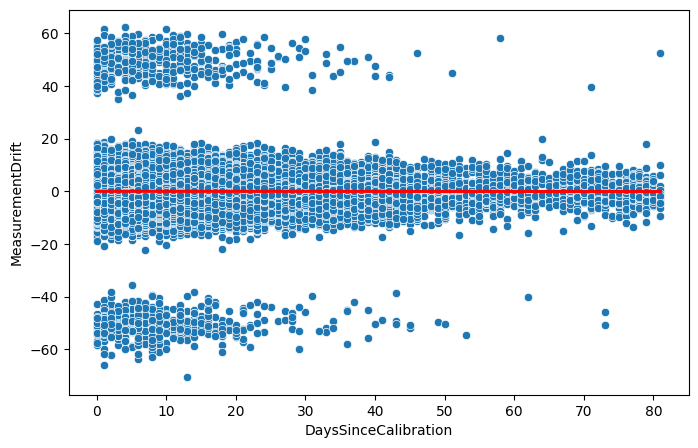

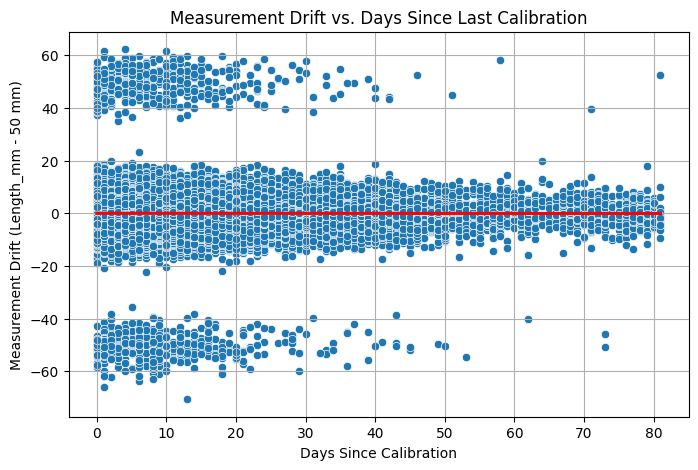

In [68]:
# Scatterplot with fit line
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.scatterplot(x='DaysSinceCalibration', y='MeasurementDrift', data=temp_tab4)
sns.regplot(x='DaysSinceCalibration', y='MeasurementDrift', data=temp_tab4, scatter=False, color='red')
plt.figure(figsize=(8, 5))
sns.scatterplot(x='DaysSinceCalibration', y='MeasurementDrift', data=temp_tab4)
sns.regplot(x='DaysSinceCalibration', y='MeasurementDrift', data=temp_tab4, scatter=False, color='red')
plt.title("Measurement Drift vs. Days Since Last Calibration")
plt.xlabel("Days Since Calibration")
plt.ylabel("Measurement Drift (Length_mm - 50 mm)")
plt.grid(True)
plt.show()

Problem statement 8

In [70]:
df= data[['OperatorID', 'BatchYieldPercentage']].dropna()
df.head()

,OperatorID,BatchYieldPercentage
0,OP006,99.26
1,OP002,95.62
2,OP008,96.09
3,OP011,96.13
4,OP019,95.12


In [73]:
temp_tab5= pd.merge(df, operator_df, on="OperatorID", how="left")
temp_tab5.head()

,OperatorID,BatchYieldPercentage,OperatorName,HireDate,Department
0,OP006,99.26,Operator_6,2016-08-30,Maintenance
1,OP002,95.62,Operator_2,2016-11-18,Maintenance
2,OP008,96.09,Operator_8,2018-11-03,Production
3,OP011,96.13,Operator_11,2020-08-16,Production
4,OP019,95.12,Operator_19,2018-09-26,Production


In [76]:
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
model= sm.ols('BatchYieldPercentage ~ C(Department)', data=temp_tab5).fit()
anova_model= anova_lm(model)
print(anova_model)

                    df         sum_sq   mean_sq         F    PR(>F)
C(Department)      2.0       4.990321  2.495161  1.192413  0.303492
Residual       99997.0  209246.705768  2.092530       NaN       NaN


In [77]:
if anova_model['PR(>F)'][0]<0.05:
    print("There’s a significant difference in mean BatchYield% between departments.")
else:
    print("No significant difference")

No significant difference


C:\Users\najmu\AppData\Local\Temp\ipykernel_14776\2069773966.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_model['PR(>F)'][0]<0.05:
